Mario Pasquato - MSCA-IF fellow, Université de Montréal - mario.pasquato@gmail.com

# Supervised learning - classification

## Goals of this unit
I will introduce a new dataset (variable star light curves) and a few general concepts from supervised classification.
We will then test out these methods on our dataset.

In [133]:
%matplotlib inline
from scipy.ndimage.filters import uniform_filter1d as uf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## A new dataset: Catalina sky survey variable stars

In [42]:
star = pd.read_csv('rrc/3023045040872.csv')
star.head()

ID           MjD     Phase      Mag  Mag_err   Period  Npts  \
0  3023045040872  54475.645767  0.909859  16.9917    0.160  0.34072   150   
1  3023045040872  54492.582086  0.617299  16.8932    0.154  0.34072   150   
2  3023045040872  54492.560801  0.554828  16.9556    0.157  0.34072   150   
3  3023045040872  54475.624277  0.846786  16.9110    0.153  0.34072   150   
4  3023045040872  54475.635040  0.878375  16.9357    0.155  0.34072   150   

        V       Amp        ra       dec  Type  
0  17.056  0.355121  96.26623 -22.99425     2  
1  17.056  0.355121  96.26623 -22.99425     2  
2  17.056  0.355121  96.26623 -22.99425     2  
3  17.056  0.355121  96.26623 -22.99425     2  
4  17.056  0.355121  96.26623 -22.99425     2

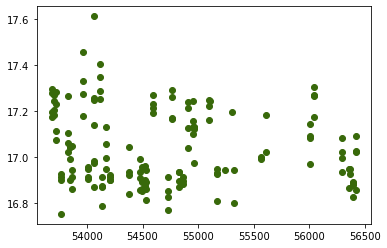

In [43]:
plt.scatter(star["MjD"], star["Mag"], color = '#38690A')
plt.show()

What is MjD? [Modified Julian Date](https://core2.gsfc.nasa.gov/time): Number of days since midnight on November 17, 1858.
What is Mag? [Magnitude](https://en.wikipedia.org/wiki/Apparent_magnitude), i.e. $M = -2.5 \log_{10} L_{\mathit{band}}/{L_0}_{\mathit{band}}$, where $L_{\mathrm{band}}$ is the flux of light received from our star in a given band and ${L_0}_{\mathit{band}}$ is the flux for a reference star of magnitude $0$. You can think of this as the minus log of the power emitted by a star that reaches a unit surface here on Earth.

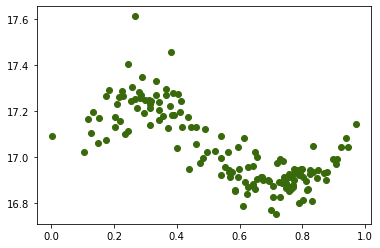

In [44]:
plt.scatter(star["Phase"], star["Mag"], color = '#38690A')
plt.show()

In [94]:
rrc_stars = os.listdir('rrc')
deltascuti_stars = os.listdir('ds')

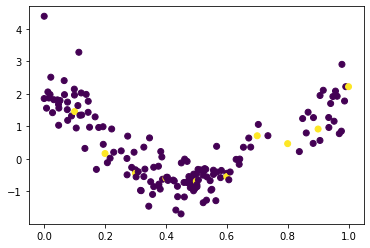

In [73]:
def scale_star_and_shift_phase(star):
    scaled_star = star.sort_values(by="Phase", axis=0)
    MEDIAN = scaled_star["Mag"].median()
    MAD = scaled_star["Mag"].mad()
    scaled_star["Mag"] = (scaled_star["Mag"] - MEDIAN)/MAD
    maximum = np.argmax(uf(scaled_star["Mag"],3))
    scaled_star["Phase"] = scaled_star["Phase"] - scaled_star.iloc[maximum, 2] 
    scaled_star["Phase"] += (scaled_star["Phase"] < 0)
    scaled_star = scaled_star.sort_values(by="Phase", axis=0)
    return(scaled_star)

def interpolate_star(star):
    smooth_star = star.iloc[:10,:].copy()
    smooth_star["Phase"] = (1.0+np.arange(10))/10.0
    smooth_star["Mag"] = np.nan 
    smooth_star["ID"] = "interpolated" 
    star = pd.concat((star, smooth_star), axis=0).sort_values(by="Phase", axis=0)
    interpolated_star = star.interpolate()
    return interpolated_star
    

scaled_star = interpolate_star(scale_star_and_shift_phase(star))
plt.scatter(scaled_star["Phase"], scaled_star["Mag"], c = scaled_star["ID"]=='interpolated')
plt.show()

We can reduce each star to 10 numbers, the magnitudes at $1/10$, ..., $1$ phase. We call these _features_. We want to classify stars in one of two groups based on these. The groups are RR-Lyrae of type c (RRc) and Delta Scuti (DS). These are called _labels_.

We assume that we know the labels for some stars. We want to use this fact to learn a function from feature space to label space. This function will predict the label based on the features. We will use it to classify new stars.

In [89]:
def featurize_star(star):
    interpolated_star = interpolate_star(scale_star_and_shift_phase(star))
    return interpolated_star[interpolated_star["ID"] == 'interpolated']["Mag"].to_numpy()

f = featurize_star(star)
print(f)
p = len(f)

[ 1.45223198  0.16143778 -0.44820226 -0.60008123 -0.69142103 -0.5469767
  0.70699836  0.46519571  0.91446007  2.2162292 ]


In [99]:
n = len(rrc_stars) + len(deltascuti_stars)
labels = np.zeros(n)
labels[:len(rrc_stars)]=1

data = np.zeros([n,p+1])
data[:,10] = labels
for i in range(len(rrc_stars)):
    data[i,:10] = featurize_star(pd.read_csv(os.path.join("rrc/", rrc_stars[i])))
for i in range(len(deltascuti_stars)):
    data[len(rrc_stars)+ i,:10] = featurize_star(pd.read_csv(os.path.join("ds/", deltascuti_stars[i])))
    
data = pd.DataFrame(data, columns = [*['f' + str(i) for i in range(10)], 'label'])
print(data)

           f0        f1        f2        f3        f4            f5        f6  \
0    1.615440  0.536114 -0.633826 -0.217900 -0.178626  3.406904e-02  0.858824   
1   -1.210435 -1.744328 -1.347030 -1.230314 -1.831074  3.422928e-02 -0.074116   
2    0.687242 -0.592758 -0.837195 -1.487771 -1.317136 -1.087272e+00 -0.284392   
3   -0.293733 -0.909762 -0.868866 -0.209346 -0.365138  5.287198e-01  0.960719   
4   -0.329804 -1.797973 -1.869227 -1.655465 -1.119025 -5.920858e-01  0.398682   
5    1.027785 -0.643909 -0.570496 -1.082673 -0.756087  3.053165e-01 -0.597254   
6    1.242821 -0.221138 -1.486766 -1.252636 -1.064986 -2.884037e-01 -0.078813   
7    1.618116  0.405295 -1.297481 -1.186389 -1.305142 -2.210353e-01  0.291904   
8    1.330455  1.017158 -1.376817 -1.025588 -1.427745 -1.004163e+00 -0.542297   
9    0.977892 -1.343982 -1.925029 -0.696463 -0.903484  2.166112e-01  0.638259   
10   1.758220 -0.114116 -0.541731 -0.432743 -0.230155  3.631838e-01  1.468442   
11   1.049888  0.988233 -0.7

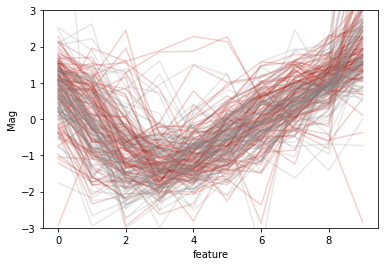

In [106]:
color = "#BA110631"
for i in range(n):
    if(i > len(rrc_stars)):
        color = "#88888831"
    plt.plot(np.arange(10), data.iloc[i, :10], color = color)

plt.ylim((-3,3))
plt.xlabel("feature")
plt.ylabel("Mag")

plt.show()

This looks like a parallel coordinate display. Because it is one, after all.

## train - test (- validation) split

In [114]:
from sklearn.model_selection import train_test_split
X = data.iloc[:,:10].to_numpy()
y = data.iloc[:,10].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=888)

We split our dataset in half: on half of it we will _train_ our model, i.e. learn a function that assigns a label to a point in feature space. On the other half we will _test_, i.e. check how well this function is at predicting on new data.

A few considerations:
* We do not know how to measure the performance of our classifier (how well it predicts) but, in general, there is no guarantee that its performance on new data will be the same as that on the data it was trained on. That's why we are doing this train-test split.
* In the following we will not adjust any parameters or make any changes to our classifier based on its performance on unseen data. If we do that we will need to test it on _other_ new data. In other words we will need a train-validation-test split rather than a train-test split. 
* There is new data and new data. Here we are just taking random slices of the same data. We just do not use some data in training. In practice we may end up testing like this and then deploying on data taken by a new instrument. Watch out for surprises, in that case. 
* There are more sophisticated approaches than a simple split, such a cross-validation.

## [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)

Let's call our feature space $\mathbf{X}$, which is typically $R^n$. In our case it's $R^{10}$ because we have $10$ real features, so $n=10$. We have two classes, $A$ and $B$, corresponding to our two types of stars.
We want to learn the probability that one data point $\mathbf{x} \in \mathbf{X}$ is of class $A$.
If we are lucky there is a simple boundary between class $A$ and class $B$ in feature space. The naivest assumption is that this boundary is an hyperplane. This is likely not the case in reality, but it may be good enough.

The equation of the boundary then would be
\begin{equation}
\mathbf{\beta} \cdot (1, \mathbf{x}) = 0
\end{equation}
where $\mathbf{\beta}$ is a row vector of $n+1$ coefficients and $(1, \mathbf{x})$ is a column vector obtained by tacking on a $1$ to $\mathbf{x}$. This suggests that we could model the probability that a data point is of class $A$ as
\begin{equation}
P(A | \mathbf{x}) = \Lambda(\mathbf{\beta} \cdot (1, \mathbf{x}))
\end{equation}
where $\Lambda: R \to ]0,1[$ is a function that tends to $0$ at minus infinity and to $1$ at plus infinity.

For logistic regression we pick
\begin{equation}
\Lambda(s) = \frac{1}{1+e^{-s}}
\end{equation}

For any given choice of $\mathbf{\beta}$ we can thus predict a probability $p_i$ of being class $A$ for each point $x_i$. But in training we also have labels $y_i$ for each point. So, given a loss function $L(y_i, p_i)$ we can minimize it to find the best coefficients $\mathbf{\beta}$, since the $p_i$ ultimately depend on $\mathbf{\beta}$.

Typically the loss function we choose is
\begin{equation}
L(y_i, p_i) = -\sum_{i=1}^n y_{i}\ln p_{i}+(1-y_{i})\ln(1-p_{i})
\end{equation}
known as the [cross entropy loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html).

Let's see how to do this in practice.

In [117]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(penalty='none')

logistic_classifier = logit.fit(X_train, y_train)

Now that we trained our classifier we can predict labels on new data

In [123]:
train_predictions = logistic_classifier.predict(X_train)
test_predictions = logistic_classifier.predict(X_test)
print(test_predictions)

[1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1.]


We can also access the internally calculated probabilities, so we know how confident the classifier is in its prediction

In [125]:
test_confidence = logistic_classifier.predict_proba(X_test)
print(test_confidence)

[[0.49518282 0.50481718]
 [0.34439853 0.65560147]
 [0.62836302 0.37163698]
 [0.58025846 0.41974154]
 [0.65354896 0.34645104]
 [0.28217079 0.71782921]
 [0.25812968 0.74187032]
 [0.30574205 0.69425795]
 [0.43776829 0.56223171]
 [0.20920933 0.79079067]
 [0.5146986  0.4853014 ]
 [0.70114566 0.29885434]
 [0.71512047 0.28487953]
 [0.43093409 0.56906591]
 [0.73889284 0.26110716]
 [0.33971884 0.66028116]
 [0.42943427 0.57056573]
 [0.76574301 0.23425699]
 [0.63634523 0.36365477]
 [0.49943402 0.50056598]
 [0.38904328 0.61095672]
 [0.72982835 0.27017165]
 [0.38151122 0.61848878]
 [0.53785891 0.46214109]
 [0.33219742 0.66780258]
 [0.16342783 0.83657217]
 [0.47362064 0.52637936]
 [0.37268277 0.62731723]
 [0.38753452 0.61246548]
 [0.20364834 0.79635166]
 [0.59745372 0.40254628]
 [0.61769415 0.38230585]
 [0.62675391 0.37324609]
 [0.58823414 0.41176586]
 [0.2609838  0.7390162 ]
 [0.56812934 0.43187066]
 [0.68577818 0.31422182]
 [0.64846586 0.35153414]
 [0.566373   0.433627  ]
 [0.61354396 0.38645604]


Of course probability of being in class $A$ and probability of being in class $B$ sum to $1$ within numerical error.

## Measuring classification accuracy: botanics

There are several (too many) ways to measure how good of a job our classifier did.
If we only have predicted labels and true labels, and no access the confidence score / probability we can still calculate four numbers: how many objects in class $A$ were classified as class $B$, how many objects in class $A$ were classified as class $A$, how many objects in class $B$ were classified as class $A$, how many objects in class $B$ were classified as class $B$. We can arrange these in a matrix.

### Confusion matrix



In [132]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, test_predictions)

array([[33, 15],
       [26, 26]])

Whoa, pretty bad. Was it this bad on training data too?

In [127]:
confusion_matrix(y_train, train_predictions)

array([[39, 13],
       [19, 29]])

Still quite bad, but somewhat less so. Let's condense these matrices into one number.

### Accuracy

In [128]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, train_predictions))
print(accuracy_score(y_test, test_predictions))

0.68
0.59


This is the number of correctly classified instances (the diagonal) over the total number. We can't do much more than that unless we break the symmetry. Let's say we care about one class more than the other, for example class $A$.

Then we call true positives $\mathrm{tp}$ the instances in class $A$ that were correctly predicted as class $A$.
Then we call true negatives $\mathrm{tn}$ the instances in class $B$ that were correctly predicted as class $B$.
Then we call false positives $\mathrm{fp}$ the instances in class $B$ that were incorrectly predicted as class $A$.
Then we call false negatives $\mathrm{fn}$ the instances in class $A$ that were incorrectly predicted as class $B$.

In many applications misclassification has a different cost in the case of a false positive and in that of a false negative. Imagine that class $A$ is people really infected with a disease. A false negative may result in misdiagnosis and even death. A false positive may require taking a more sensitive test to double check.

### Precision

Precision is defined as $\mathrm{Pr} = \mathrm{tp} / (\mathrm{tp} + \mathrm{fp})$. How many of the people classified as sick are really sick? How many of the fishes we catch are yellowfin tuna?

In [129]:
from sklearn.metrics import precision_score
print(precision_score(y_train, train_predictions))
print(precision_score(y_test, test_predictions))

0.6904761904761905
0.6341463414634146


### Recall

Recall is defined as $\mathrm{Re} = \mathrm{tp} / (\mathrm{tp} + \mathrm{fn})$. How many of the people who really are sick do we classify as sick? How many yellowfish tuna do we catch among all those that are there in the sea?

In [130]:
from sklearn.metrics import recall_score
print(recall_score(y_train, train_predictions))
print(recall_score(y_test, test_predictions))

0.6041666666666666
0.5


### F score

The F-score or F1-score is defined as the harmonic mean of precision and recall: $F = 2 * (1/\mathrm{Re} + 1/\mathrm{Pr})^{-1}$.

Note that we can reach perfect recall ($Re = 1$) if classify everybody as sick. But by doing that we sacrifice precision. On the other hand we can reach perfect precision if we classify nobody as sick, but then recall drops to $0$. To get a high $F$ score both precision and recall need to be high. 

In [131]:
from sklearn.metrics import f1_score
print(f1_score(y_train, train_predictions))
print(f1_score(y_test, test_predictions))

0.6444444444444444
0.5591397849462365
